In [1]:
%pip install numpy
%pip install matplotlib
%pip install pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_cols = ['Glucose', 'BMI']
output_col = 'Outcome'

plt.style.use('dark_background')
data = pd.read_csv('datasets/diabetes.csv',
                   usecols=[*input_cols, output_col])
data.dropna()



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,Glucose,BMI,Outcome
0,148,33.6,1
1,85,26.6,0
2,183,23.3,1
3,89,28.1,0
4,137,43.1,1
...,...,...,...
763,101,32.9,0
764,122,36.8,0
765,121,26.2,0
766,126,30.1,1


# Lecture 3 - Locally Weighted & Logical Regression

## Local Weighted Linear Regression
In linear regression, we can compute a hypothesis value for a given value, $x$.

This value however, is based off of all features, and parameters. 

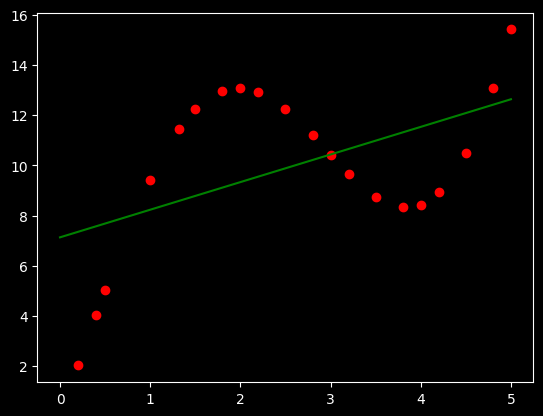

In [8]:

def normal_equation(df: pd.DataFrame):
    X = df[input_cols]
    X = np.c_[np.ones(X.shape[0]), X]
    y = df[output_col]
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def f(x):
    return x**2 + 10*np.sin(x)

input_cols = ['x']
output_col = 'y'

data = {}
data[input_cols[0]] = np.array([0.2, 0.4, 0.5, 1, 1.32, 1.5, 1.8, 2, 2.2, 2.5, 2.8, 3, 3.2, 3.5, 3.8, 4, 4.2, 4.5, 4.8, 5])
data[output_col] = f(data[input_cols[0]])  
# data = pd.read_csv('datasets/weather.csv',
#                    usecols=[*input_cols, output_col],)
# print(data)
df = pd.DataFrame(data)
df.dropna()

x = df[input_cols].values.flatten()
y = df[output_col].values.flatten()
parameters = normal_equation(df)

plt.scatter(x, y, c='r')

# # Initialize the starting point
# x_0 = 3

# # Plot the function and the progress of gradient descent
hyp_x = np.linspace(0, 5, 100)
hyp_y = parameters[0] + parameters[1] * hyp_x

# # d/dx = 0 : https://www.wolframalpha.com/input?i=2x+%2B+10cos%28x%29+%3D+0
# # Minimum points: -1.30644, 3.83747

plt.plot(hyp_x, hyp_y, label='f(x)', c='g')
# plt.plot(x, y_lr, label='f(x)', c='r')
# # plt.scatter(np.array(min_pts), 
# #             f(np.array(min_pts)), 
# #             c='r', 
# #             label='Miminum points')
# plt.legend()
plt.show()

The hypothesis function is far more accurate at some points than others. Take for instance the gradients of both $x$ ranges, $[2, 3]$ and $[1.5, 2]$. 
The gradients of both functions are drastically different. Thus, the hypothesis function will be more accurate at some points than others.

We consider these ranges as _locals_. Notice, the gradients of points within a local are similar.  

Thus, if we want to only consider based on a _local_, we can use a weight value to determine how much an example should influence the estimation given the point of interest.

To do this, we will modify our cost function, $J(\theta)$, to include a weight value, $w^{(i)}$.
$$J(\theta) = \frac{1}{2}\sum_{i=1}^m w^{(i)}(h_\theta(x^{(i)}) - y^{(i)})^2$$
We can represent this in vectorized form as:
$$J(\theta) = \frac{1}{2}(X\theta - y)^T W (X\theta - y)$$

Where $W$ is a diagonal matrix, where the diagonal values are the weight values, $w^{(i)}$.

$w^{(i)}$ is a weight value that is computed based on some weight function like the following:
$$w^{(i)} = exp\left(-\frac{(x^{(i)} - x)^2}{2\tau^2}\right)$$

In this weight function, notice how we are computing the exponent based on the distance of $x^{(i)}$ from $x$.

$$(x^{(i)} - x)^2$$

If $x$ is 5:
- and $x^{(i)}$ is 5, then this difference is $0$, and the squared difference is $0$.
- and $x^{(i)}$ is 7, then this difference is $2$, and the squared difference is $4$.

In the weight function, we divide this squared difference by $2\tau^2$. $\tau$ is a parameter that determines the 'size' of the local. The larger the $\tau$, the larger the local.

Finally, notice that we take the negative of this value. This is because we want the weight value to be between 0 and 1. When we take the exponent to a negative value, we are essentially inverting the value.

This means that, for distances that are far away from $x$, the weight value will be close to 0, meaning there will be less influence on the hypothesis function. Conversely, for distances that are close to $x$, the weight value will be close to 1, meaning there will be more influence on the hypothesis function.

$$exp\left(-\frac{(x^{(i)} - x)^2}{2\tau^2}\right)$$




In [6]:
%pip install numpy
%pip install matplotlib
%pip install pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Main Implementation of Gradient Descent.

def hypothesis(x: list[float] = [], parameters: list[float] = []):
    # print(f"{x} {parameters}")
    return np.dot(x, parameters)

def calc_cost_for_example(x: list[float] = [], y = 0, parameters: list[float] = []) -> float:
    return (hypothesis(x, parameters) - y)**2

def calc_cost_for_row(row: pd.Series, parameters: list[float] = []) -> float:
    return calc_cost_for_example(
        [1, *map(lambda inp: row[inp], input_cols)],
        row[output_col],
        parameters
    )

def calc_total_cost(df: pd.DataFrame, parameters: list[float] = []) -> float:
    return df.apply(
        lambda row: calc_cost_for_row(row, parameters),
        axis=1
    ).sum()

def calc_average_cost(df: pd.DataFrame, parameters: list[float] = []) -> float:
    return calc_total_cost(df, parameters) / (2 * df.shape[0])

def calc_derrivative_for_example(x: list[float] = [], 
                                 y = 0,
                                 parameters: list[float] = [],
                                 parameter_index = 0) -> float:
    return (hypothesis(x, parameters) - y) * x[parameter_index]

def calc_derrivative_for_row(row: pd.Series, 
                             parameters: list[float] = [],
                             parameter_index = 0) -> float:
    return calc_derrivative_for_example(
        [1, *map(lambda inp: row[inp], input_cols)],
        row[output_col],
        parameters,
        parameter_index
    )

# Sandbox utility functions - not used in the main implementation.
def plot(df: pd.DataFrame, parameter_snapshots: list[list[float]] = []):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel(input_cols[0])
    ax.set_ylabel(input_cols[1])
    ax.set_zlabel(output_col)
    for row in df.iterrows():
        ax.scatter(row[1][input_cols[0]], row[1][input_cols[1]], row[1][output_col], c='b')

    # Show all parameter snapshots as a line
    numb_snapshots = len(parameter_snapshots)
    for i in range(numb_snapshots):
        snapshot = parameter_snapshots[i]
        x = np.linspace(-10, 40, 50)
        y = np.linspace(-10, 40, 50)
        z = x * snapshot[1] + y * snapshot[2] + snapshot[0]
        
        color = i == numb_snapshots - 1 and 'r' or 'g'
        ax.plot(x, y, z, c=color)
    plt.show()

def try_out(parameters: list[float] = []):
    print(f"Using parameters: {parameters}")
    while True:
        inp = input("Enter (windSpeed, temperature) or 'q' to quit:")
        if inp == 'q':
            break
        windSpeed, temperature = map(float, inp.split(','))
        rainfall = hypothesis([1, windSpeed, temperature], parameters)
        print(f"Predicted rainfall for {windSpeed}, {temperature}: {rainfall}")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Logistic Regression
In classification, the hypothesis function produces a desired output.

In this section, we will only consider a case where the desired output is binary, either 0 or 1.

Say that we were given some set of examples where after a certain value of $x$, the output is 1, and before that value, the output is 0.

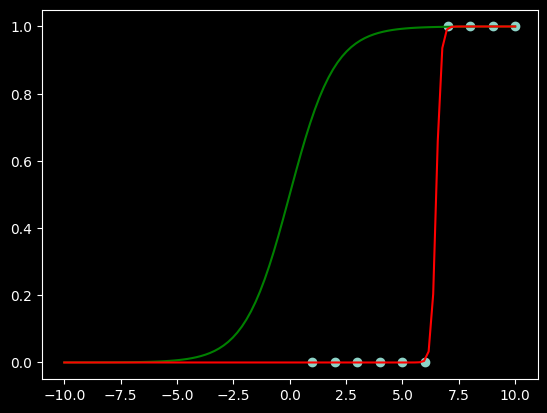

In [24]:
def normal_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def data_fit_sigmoid(x):
    return 1 / (1 + np.exp(-(10 * x - 65)))

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
x_linespace = np.linspace(-10, 10, 100)
y_dfs_linespace = data_fit_sigmoid(x_linespace)
y_normal_linespace = normal_sigmoid(x_linespace)

plt.scatter(x, y)
plt.plot(x_linespace, y_normal_linespace, c='g')
plt.plot(x_linespace, y_dfs_linespace, c='r')
plt.show()


Notice above, the trend of the data starts off from 0 then increases to 1.

We can fit the data using a sigmoid function (shown in green), $g(x)$, is defined as:
$$g(x) = \frac{1}{1 + e^{-x}}$$

We can control the exponent of $e$ to better fit the data. For instance, if we want to fit the data to a sigmoid function, we can modify the sigmoid function like so (shown in red):
$$f(x) = \frac{1}{(1+e^{-(10x - 65)})}$$

We treat the sigmoid function as a hypothesis function, whereby the output is the __probability__ of the data point being classified as $1$.
$$h_\theta(x) = g(\theta^Tx)$$
$$h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}$$
We can represent this hypothesis function in probability form as:
$$P(y = 1 | x; \theta) = h_\theta(x)$$

If the probability returned is $\geq 0.5$, then we classify the data point as $1$. Otherwise, we classify the data point as $0$. Note here, $0$ and $1$ is used to represent 2 possible outputs like 'yes' and 'no'.

The goal of logistic regression is to find the best parameters, $\theta$, that maximizes the probability of each data point being classified correctly. Take for instance above, if we were to use the _green_ sigmoid function, we would have classified all our data points incorrectly as $1$ despite values of $x \leq 6$ should classified as $0$. We want to maximize the __likelihood__ of matching _all_ the data points correctly.

### Likehood
We can think of _likelihood_ as a probability or a score of how well the hypothesis function fits the data. The higher the likelihood, the better the hypothesis function fits the data.

Recall, the hypothesis function represents the probability of a data point being classified as $1$. We can describe this as:
$$P(y^{(i)} = 1 | x^{(i)}; \theta) = h_\theta(x^{(i)})$$
Conversely, we can describe the probability of a data point being classified as $0$ (Not being the other option, $1$) as:
$$P(y^{(i)} = 0 | x^{(i)}; \theta) = 1 - h_\theta(x^{(i)})$$

We can combine these two probabilities into one probability as:
$$P(y^{(i)} | x^{(i)}; \theta) = h_\theta(x^{(i)})^{y^{(i)}}(1 - h_\theta(x^{(i)}))^{1 - y^{(i)}}$$
Notice, if $y^{(i)} = 1$, then the probability is $h_\theta(x^{(i)})$. If $y^{(i)} = 0$, then the probability is $1 - h_\theta(x^{(i)})$. These exponents are used to toggle which probability function to use based on the value of $y^{(i)}$.

The likelihood of our data is the __product of probabilities__ of all our data.
$$L(\theta) = P(y|x;\theta) = \prod_{i=1}^m P(y^{(i)} | x^{(i)}; \theta)$$
$$= \prod_{i=1}^m h_\theta(x^{(i)})^{y^{(i)}}(1 - h_\theta(x^{(i)}))^{1 - y^{(i)}}$$

### Log Likelihood
Later on, we will see that we can use the log of the likelihood to simplify our derivative calculations. Finding the derrivative of a sum is easier than finding the derivative of a product.

We can represent the log of the likelihood as:
$$l(\theta) = ln(L(\theta)) = ln(\prod_{i=1}^m h_\theta(x^{(i)})^{y^{(i)}}(1 - h_\theta(x^{(i)}))^{1 - y^{(i)}})$$
Using the product rule, we can expand the log of the likelihood as:
$$= \sum_{i=1}^m ln(h_\theta(x^{(i)})^{y^{(i)}}(1 - h_\theta(x^{(i)}))^{1 - y^{(i)}})$$
$$= \sum_{i=1}^m ln(h_\theta(x^{(i)})^{y^{(i)}}) + ln(1 - h_\theta(x^{(i)})^{(1 - y^{(i)})})$$

Using the power rule, we can expand the log of the likelihood as:
$$= \sum_{i=1}^m y^{(i)}ln(h_\theta(x^{(i)})) + (1 - y^{(i)})ln(1 - h_\theta(x^{(i)}))$$

### Gradient Ascent
Recall, we want to maximize the likelihood function, $L(\theta)$. 

Similar to gradient descent, we can use the derivative of the log likelihood function, $l(\theta)$, to gravitate to a local maximum.
$$\theta_j := \theta_j + \alpha \frac{\partial l(\theta)}{\partial \theta_j}$$

Whereby $\frac{\partial l(\theta)}{\partial \theta_j}$ is the partial derivative of the log likelihood function with respect to $\theta_j$.:
$$\frac{\partial l(\theta)}{\partial \theta_j} = \frac{\partial}{\partial \theta_j} \sum_{i=1}^m y^{(i)}ln(h_\theta(x^{(i)})) + (1 - y^{(i)})ln(1 - h_\theta(x^{(i)}))$$

Using the sum rule of differentiation, we can expand the partial derivative of the log likelihood function as:
$$= \sum_{i=1}^m \frac{\partial}{\partial \theta_j} [y^{(i)}ln(h_\theta(x^{(i)})) + (1 - y^{(i)})ln(1 - h_\theta(x^{(i)}))]$$
$$= \sum_{i=1}^m \frac{\partial}{\partial \theta_j} [y^{(i)}ln(h_\theta(x^{(i)}))] + \frac{\partial}{\partial \theta_j} [(1 - y^{(i)})ln(1 - h_\theta(x^{(i)}))]$$

Let's now apply the differentiation log rule, $\frac{d}{dx} ln(f(x)) = \frac{1}{f(x)}f'(x)$:
$$= \sum_{i=1}^m \frac{y^{(i)}}{(h_\theta(x^{(i)}))} \frac{\partial}{\partial \theta_j} h_\theta(x^{(i)}) + \frac{1 - y^{(i)}}{1 - h_\theta(x^{(i)})} \frac{\partial}{\partial \theta_j} [1 - h_\theta(x^{(i)})]$$

Using the sum rule of differentiation, we can expand the partial derivative of the log likelihood function as:
$$= \sum_{i=1}^m \frac{y^{(i)}}{(h_\theta(x^{(i)}))} \frac{\partial}{\partial \theta_j} h_\theta(x^{(i)}) + \frac{1 - y^{(i)}}{1 - h_\theta(x^{(i)})} [\frac{\partial}{\partial \theta_j} 1 - \frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})]$$
$$= \sum_{i=1}^m \frac{y^{(i)}}{(h_\theta(x^{(i)}))} \frac{\partial}{\partial \theta_j} h_\theta(x^{(i)}) - \frac{1 - y^{(i)}}{1 - h_\theta(x^{(i)})} \frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})$$

Now let's factor out the partial derivative of $h_\theta(x^{(i)})$:
$$= \sum_{i=1}^m [\frac{y^{(i)}}{(h_\theta(x^{(i)}))} - \frac{1 - y^{(i)}}{1 - h_\theta(x^{(i)})}]\frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})$$

Let's first deal with the terms inside the $[]$:
$$= \sum_{i=1}^m [\frac{y^{(i)} - y^{(i)}(h_\theta(x^{(i)})) - h_\theta(x^{(i)}) + y^{(i)}(h_\theta(x^{(i)}))}{(h_\theta(x^{(i)})) - (h_\theta(x^{(i)}))^2}]\frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})$$
$$= \sum_{i=1}^m [\frac{y^{(i)} - h_\theta(x^{(i)})}{(h_\theta(x^{(i)})) - (h_\theta(x^{(i)}))^2}]\frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})$$

Now let's only focus on the derivative.
$$h_\theta(x^{(i)}) = \frac{1}{1 + e^{-\theta^Tx^{(i)}}}$$
$$\frac{\partial}{\partial \theta_j} h_\theta(x^{(i)}) = \frac{\partial}{\partial \theta_j} \frac{1}{1 + e^{-\theta^Tx^{(i)}}}$$

Notice, we are passing the function $z = \theta^Tx^{(i)}$ into the sigmoid function $g(z) = \frac{1}{1 + e^{-z}}$, making it a composite function. This means that we can use the chain rule to expand the derivative of the composite function:
$$= \frac{\partial g}{\partial z} \frac{\partial z}{\partial \theta_j}$$
$$= \frac{\partial}{\partial z} \frac{1}{1 + e^{-z}} \frac{\partial}{\partial \theta_j} \theta^T x$$

Using the quotient rule when differentiating the sigmoid function, we have,
$$= \frac{(1 + e^{-z})(0) - 1 (-e^{-z})}{(1 + e^{-z})} \frac{\partial}{\partial \theta_j} \theta^T x$$
$$= \frac{e^{-z}}{(1 + e^{-z})^2} \frac{\partial}{\partial \theta_j} \theta^T x$$

Later on, we want to represent this derivative different, to make it easier to compute.
$$= \frac{(-1 + 1) + e^{-z}}{(1 + e^{-z})^2} \frac{\partial}{\partial \theta_j} \theta^T x$$
$$= [\frac{1 + e^{-z}}{(1 + e^{-z})^2} + \frac{-1}{(1 + e^{-z})^2}] \frac{\partial}{\partial \theta_j} \theta^T x$$
$$= [\frac{1}{(1 + e^{-z})} - \frac{1}{(1 + e^{-z})^2}] \frac{\partial}{\partial \theta_j} \theta^T x$$

Factoring out the common term, we have
$$= \frac{1}{(1 + e^{-z})}[1 - \frac{1}{(1 + e^{-z})}] \frac{\partial}{\partial \theta_j} \theta^T x$$

Finally, lets deal with the other derivative. Recall when doing regression, we can represent $\frac{\partial}{\partial \theta_j} \theta^T x$ as $\frac{\partial}{\partial \theta_j} \theta^T x = x_j$.
Thus,
$$= \frac{1}{(1 + e^{-z})}[1 - \frac{1}{(1 + e^{-z})}] x_j$$

Now, lets substitute back $z = \theta^Tx^{(i)}$ into the sigmoid function, $h_\theta(x^{(i)}) = \frac{1}{(1 + e^{-z})}$. We can represent what we derived in the form:
$$= h_\theta(x^{(i)})[1 - h_\theta(x^{(i)})] x_j$$

Going back to the original equation, we have
$$\sum_{i=1}^m [\frac{y^{(i)} - h_\theta(x^{(i)})}{(h_\theta(x^{(i)})) - (h_\theta(x^{(i)}))^2}]\frac{\partial}{\partial \theta_j} h_\theta(x^{(i)})$$
$$= \sum_{i=1}^m [\frac{y^{(i)} - h_\theta(x^{(i)})}{(h_\theta(x^{(i)})) - (h_\theta(x^{(i)}))^2}] h_\theta(x^{(i)})[1 - h_\theta(x^{(i)})] x_j$$
$$= \sum_{i=1}^m [\frac{y^{(i)} - h_\theta(x^{(i)}) ([h_\theta(x^{(i)}) - h_\theta(x^{(i)})^2] x_j)}{(h_\theta(x^{(i)})) - (h_\theta(x^{(i)}))^2}]$$
$$= \sum_{i=1}^m (y^{(i)} - h_\theta(x^{(i)})) x_j$$

References:
- https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/pdfs/40%20LogisticRegression.pdf
- https://arunaddagatla.medium.com/maximum-likelihood-estimation-in-logistic-regression-f86ff1627b67


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   Glucose  Outcome
0      148        1
1       85        0
2      183        1
3       89        0
4      137        1
Iteration 0: [-1.9666883680555553e-05, -0.0014523050091574344] - 6.920967556085991e-228
Iteration 1: [-3.363550069074498e-05, -0.0021678967649024572] - 6.6567776554855795e-227
Iteration 2: [-4.482845930797601e-05, -0.002525115841406931] - 1.1732235937197478e-226
Iteration 3: [-5.464896358954907e-05, -0.0027053335333162365] - 1.3562295329530014e-226
Iteration 4: [-6.378091781178363e-05, -0.0027968116944962072] - 1.4083923994505991e-226
Iteration 5: [-7.25643367537031e-05, -0.0028433886088912374] - 1.4227147155273536e-226
Iteration 6: [-8.117046097249871e-05, -0.00286713043750282] - 1.4269156494140728e-226
Iteration 7: [-8.968616002584371e-05, -0.0028792280086432764] - 1.4284

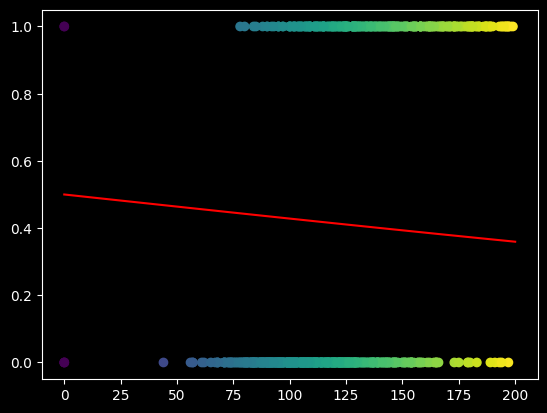

In [89]:
%pip install numpy
%pip install matplotlib
%pip install pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# input_cols = ['Glucose', 'Pregnancies']
input_cols = ['Glucose']
output_col = 'Outcome'
# input_cols = ['radius_mean', 'area_mean']
# input_cols = [*"radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst".split(",")]
# output_col = 'diagnosis'

plt.style.use('dark_background')
data = pd.read_csv('datasets/diabetes.csv',
                   usecols=[*input_cols, output_col])

# Main Implementation of Gradient Ascent.
def hypothesis(x: list[float] = [], parameters: list[float] = []):
    exp = np.dot(np.array(parameters).transpose(), np.array(x))
    return 1 / (1 + np.exp(-exp))

def calc_ll_derivative_for_j_param(jIndex: int, 
                                   examples: list[tuple[list[float]], float] = [],
                                   parameters: list[float] = []) -> float:
    example_size = len(examples)

    tally = 0
    for i in range(example_size):
        example_x = [1, *examples[i][0]] 
        # print(f"example_x: {len(example_x)} - parameters: {len(parameters)} - jIndex: {jIndex} - i: {i}")
        tally += examples[i][1] * example_x[jIndex] - hypothesis(example_x, parameters) * example_x[jIndex]
    return tally / example_size

# def calc_ll_for_examples(examples: list[tuple[list[float]], float] = [], parameters: list[float] = []) -> float:
#     return sum(map(lambda example: example[1] * np.log(hypothesis([1, *example[0]], parameters)) + (1 - example[1]) * np.log(1 - hypothesis([1, *example[0]], parameters)), examples))

def calc_likelihood_for_examples(examples: list[tuple[list[float]], float] = [], parameters: list[float] = []) -> float:
    likelihood = 1
    for example in examples:
        p = hypothesis([1, *example[0]], parameters)
        likelihood *= ((p)**example[1]) * ((1 - p)**(1 - example[1])) 

    return likelihood

# Utility functions
# def plot(df: pd.DataFrame, parameter_snapshots: list[list[float]] = []):
#     ax = plt.figure().add_subplot(projection='3d')
#     ax.set_xlabel(input_cols[0])
#     ax.set_ylabel(input_cols[1])
#     ax.set_zlabel(output_col)
    
#     ax.scatter(df[input_cols[0]], df[input_cols[1]], df[output_col], cmap='viridis', c=df[input_cols[0]] * df[input_cols[1]])
    
#     # Show all parameter snapshots as a line
#     numb_snapshots = len(parameter_snapshots)
#     for i in range(numb_snapshots):
#         snapshot = parameter_snapshots[i]
#         x = np.linspace(0, 200, 50)
#         y = np.linspace(20, 80, 50)
#         if len(x) != len(y):
#             raise Exception("x and y must be the same length")
#         z = [z_i for z_i in map(lambda x_i, y_i: hypothesis([1, x_i, y_i], snapshot), x, y)]

#         color = i == numb_snapshots - 1 and 'r' or 'g'
#         ax.plot(x, y, z, c=color)
#     plt.show()

# --
df = pd.DataFrame(data)
df.dropna()
# df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
print(df.head())

number_of_examples = df.shape[0]

iterations = 10
learning_rate = 0.1 
parameters = [0] * (len(input_cols) + 1)

parameter_snapshots = []
for i in range(iterations):
    for j in range(len(parameters)):
        d_cost = 0

        examples = []
        for example in range(number_of_examples):
            example_row = df.iloc[example]
            inps = [*(inp for inp in example_row[input_cols])]
            examples.append([inps, example_row[output_col]])
        
        d_cost = calc_ll_derivative_for_j_param(
            j, 
            examples,
            parameters
        ) / number_of_examples
        
        delta = d_cost 
        parameters[j] = parameters[j] + learning_rate * delta
        parameter_snapshots.append(parameters.copy())
    print(f'Iteration {i}: {parameters} - {calc_likelihood_for_examples(examples, parameters)}')

# plot(df, parameter_snapshots)

# print(df)
# plot(df, [[0.2, 4.4, -8]])

plt.style.use('dark_background')
# 2d
plt.scatter(df[input_cols[0]], df[output_col], c=df[input_cols[0]])
# Plot sigmoid based on parameters
x_linespace = np.linspace(0, 200, 50)
plt.plot(x_linespace, [hypothesis([1, x], parameters) for x in x_linespace], c='r')
plt.show()
